In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import torch
import torch.nn as nn
# from torch.autograd import Variable  - 现在已经自动集成到Tensor中了
# 加载数据的包
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

print(train.head())
print(test.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [4]:
# split train data into features and labels
# test data has no labels
# labels
targets_numpy = train.label.values
print(f"targets_numpy: {targets_numpy} \n\n")
print(f"train.label: \n {train.label} \n\n")

# features - 所有行，除了label之外的列
features_numpy = train.loc[:, train.columns != "label"].values.astype(float)/255
print(f"features_numpy: \n{features_numpy}")

targets_numpy: [1 0 1 ... 7 6 9] 


train.label: 
 0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64 


features_numpy: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
labelsTest = torch.tensor(targets_numpy, dtype=torch.float32)
featuresTest = torch.tensor(features_numpy, dtype=torch.float32)
print("labelsTest.shape: ", labelsTest.shape)
print("featuresTest.shape: ", featuresTest.shape)

labelsTest.shape:  torch.Size([42000])
featuresTest.shape:  torch.Size([42000, 784])


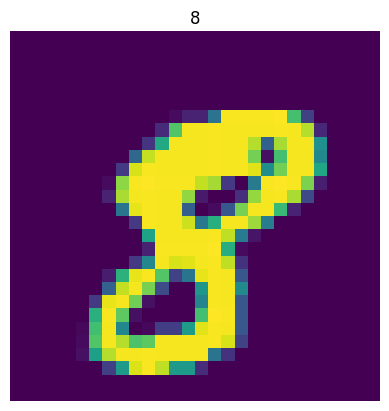

In [6]:
batch_size = 100
epochs = 200

# 先把数据的特征和标签对应组合成元组，然后再在里面取值
train_combine = torch.utils.data.TensorDataset(featuresTest, labelsTest)
train_loader = torch.utils.data.DataLoader(train_combine, batch_size=batch_size, shuffle=False)

# visulaize one of the images in data set
plt.imshow(features_numpy[10].reshape(28, 28))
# 关闭坐标轴的显示，因为图片不需要坐标轴
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.show()

In [7]:
# define the logistic regression model
class Logistic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Logistic, self).__init__()
        
        # Linear part
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        out = self.linear(x)
        return out

In [8]:
input_dim = 28 * 28
output_dim = 10

# 实例化模型 - 注意同时把model移动到cuda上
model = Logistic(input_dim, output_dim).to("cuda")

# loss
# 交叉熵损失 - 输入是浮点型FloatTensor，输出是长整形LongTensor
loss = nn.CrossEntropyLoss()

# SGD
lr = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

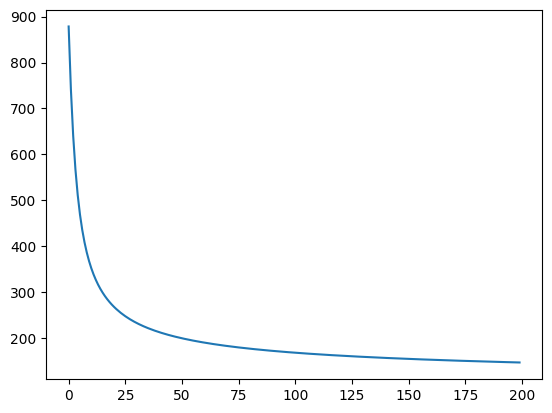

In [9]:
train_ls = []
for epoch in range(epochs):
    loss_sum = 0
    for images, labels in train_loader:
        images, labels = images.to("cuda"), labels.to("cuda")
        labels = labels.long()
        l = loss(model(images), labels)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        loss_sum += l.item()
    train_ls.append(loss_sum)
plt.plot(range(epochs), train_ls)
plt.show()

In [10]:
import numpy as np
def Test(test):
    test_tensor = torch.tensor(test.values, dtype=torch.float32)
    test_tensor = test_tensor.to("cuda")
    with torch.no_grad():
        # 返回最大值和最大值的索引，这里_接收的是值，不关心，preds是索引
        # 输出就10个数，找出最大的数的索引来，索引就可以当作数本身
        _, preds = torch.max(model(test_tensor).data, 1)
    print(f"preds: {preds} \n")
    return preds.cpu().numpy()
Label = Test(test)
ImageId = np.arange(1, len(Label)+1)
submission = pd.DataFrame({
    'ImageId': ImageId,
    'Label': Label
})
print(submission)
submission.to_csv('submission.csv', index=False)

preds: tensor([2, 0, 9,  ..., 3, 9, 2], device='cuda:0') 

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]
